<h1>laser_cutting_model<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Импорт-библиотек" data-toc-modified-id="Импорт-библиотек-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Импорт библиотек</a></span></li><li><span><a href="#Подготовка-к-эксперименту" data-toc-modified-id="Подготовка-к-эксперименту-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка к эксперименту</a></span><ul class="toc-item"><li><span><a href="#План-предобработки" data-toc-modified-id="План-предобработки-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>План предобработки</a></span></li><li><span><a href="#Эксперимент" data-toc-modified-id="Эксперимент-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Эксперимент</a></span></li><li><span><a href="#&quot;Pipeline&quot;" data-toc-modified-id="&quot;Pipeline&quot;-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>"Pipeline"</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Разделим-на-выборки" data-toc-modified-id="Разделим-на-выборки-2.4.1"><span class="toc-item-num">2.4.1&nbsp;&nbsp;</span>Разделим на выборки</a></span></li><li><span><a href="#Baseline" data-toc-modified-id="Baseline-2.4.2"><span class="toc-item-num">2.4.2&nbsp;&nbsp;</span>Baseline</a></span></li><li><span><a href="#Стандартная-линейная-регрессия" data-toc-modified-id="Стандартная-линейная-регрессия-2.4.3"><span class="toc-item-num">2.4.3&nbsp;&nbsp;</span>Стандартная линейная регрессия</a></span></li></ul></li><li><span><a href="#Сравнение-baseline-и-regression" data-toc-modified-id="Сравнение-baseline-и-regression-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Сравнение baseline и regression</a></span></li><li><span><a href="#Улучшение-модели-(регуляризация)" data-toc-modified-id="Улучшение-модели-(регуляризация)-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Улучшение модели (регуляризация)</a></span><ul class="toc-item"><li><span><a href="#lasso" data-toc-modified-id="lasso-2.6.1"><span class="toc-item-num">2.6.1&nbsp;&nbsp;</span>lasso</a></span></li><li><span><a href="#ridge" data-toc-modified-id="ridge-2.6.2"><span class="toc-item-num">2.6.2&nbsp;&nbsp;</span>ridge</a></span></li><li><span><a href="#ElasticNet" data-toc-modified-id="ElasticNet-2.6.3"><span class="toc-item-num">2.6.3&nbsp;&nbsp;</span>ElasticNet</a></span></li></ul></li><li><span><a href="#Сравнение-результатов" data-toc-modified-id="Сравнение-результатов-2.7"><span class="toc-item-num">2.7&nbsp;&nbsp;</span>Сравнение результатов</a></span></li><li><span><a href="#Улучшение-модели-(полином)" data-toc-modified-id="Улучшение-модели-(полином)-2.8"><span class="toc-item-num">2.8&nbsp;&nbsp;</span>Улучшение модели (полином)</a></span></li></ul></li><li><span><a href="#Визуализация-результатов" data-toc-modified-id="Визуализация-результатов-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Визуализация результатов</a></span></li><li><span><a href="#Итог" data-toc-modified-id="Итог-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Итог</a></span></li></ul></div>

# Импорт библиотек

Импорты и функции вынесены в отдельный файл

In [1]:
import sys
sys.path.append('../')

In [2]:
from src.utils import *

# Подготовка к эксперименту 

Загрузим данные и сразу переименуем признаки

In [3]:
link = "../data/laser_cutting.csv"
data = pd.read_csv(link, on_bad_lines="skip")
data.rename(columns={'Наименование': 'Part_name',
                        'Материал': 'Material',
                        'Время': 'Time',
                        'Ширина': 'Width',
                        'Длина': 'Length',
                        'Длина реза': 'Cut_length',
                        'Кол-во резов': 'Cut_quantity',
                        'Операция': 'Operation'}, inplace=True)

In [4]:
data.head()

,Part_name,Material,Operation,hash,Time,Width,Length,Cut_length,Cut_quantity
0,Круг 40,"Лист х/к т. 3,0 мм.",ЛР,42af1b9fc3,00:00:03.5,40.000,40.000,126,1
1,Круг 40,"Лист х/к т. 3,0 мм.",ЛР,42af1b9fc3,00:00:03.5,40.000,40.000,126,1
2,Круг 40,"Лист х/к т. 3,0 мм.",ЛР,42af1b9fc3,00:00:03.5,40.000,40.000,126,1
3,Круг 40,"Лист х/к т. 3,0 мм.",ЛР,42af1b9fc3,00:00:03.5,40.000,40.000,126,1
4,Круг 40,"Лист х/к т. 3,0 мм.",ЛР,42af1b9fc3,00:00:03.5,40.000,40.000,126,1


Удаляем дубли по hash

In [5]:
data.drop_duplicates(subset='hash', inplace=True)

Проведем эксперимент,

за baseline возьмем предсказание по формуле t = V*S,

обучать будем модель линейной регрессии

## План предобработки

1. Столбец part_name:

    1.1 удалять\не удалять дубли
    
2. Столбец part_name - вытащить keywords
3. material:

    3.1 Сгруппировать материалы
    
    3.2 Вытащить из наименования материала марку и толщину (ошибки сразу удаляем, добавить фильтр по толщине 0<t<20)
    
    3.3 посчитать среднюю скорость резания, сгруперованную по материалу
    
4. Time преобразовать
5. W, L фильтр по размерам
6. заполнить пропуски
7. создать признаки
8. ввести фильтр на выбросы по cut_length + time
9. Преобразовать признаки
10. Поделить выборки

Разные подходы к обработке могут быть:

п.1 - удалять и нет

п.2 - разная логика формирования keywords

п.7 использовать разные признаки 

п.9 использовать разные кодировщики

## Эксперимент

## "Pipeline"

Скопируем данные для перевого эксперимента

In [6]:
exp1 = data.copy()

Для первого эксперимента не будем удалять дубли в наименовании изделия

Добавим признак keywords

In [7]:
exp1 = add_keywords(exp1, 'Part_name')
exp1.head(3)

,Part_name,Material,Operation,hash,Time,Width,Length,Cut_length,Cut_quantity,keywords,keywords_count
0,круг 40,"Лист х/к т. 3,0 мм.",ЛР,42af1b9fc3,00:00:03.5,40.000,40.000,126,1,[круг],8.000
14,"след 1,3 ст3.л3,0","Лист х/к т. 3,0 мм.",ЛР,42d871d3ed,00:00:07.5,62.000,111.000,304,1,"[след, стл]",3.000
17,100-15.214.03 перекладина низ,"Труба проф. 40*40*2,0",ТР,1588a8230e,00:00:46.7,356.000,155.000,581,12,"[перекладина, низ]",93.000


Добавим признак - тип материала

In [8]:
exp1['Material']=exp1['Material'].apply(lambda x: x.strip().lower())
exp1['Material_mark'] = exp1['Material'].apply(get_material_mark)
exp1.head(3)

,Part_name,Material,Operation,hash,Time,Width,Length,Cut_length,Cut_quantity,keywords,keywords_count,Material_mark
0,круг 40,"лист х/к т. 3,0 мм.",ЛР,42af1b9fc3,00:00:03.5,40.000,40.000,126,1,[круг],8.000,Сталь
14,"след 1,3 ст3.л3,0","лист х/к т. 3,0 мм.",ЛР,42d871d3ed,00:00:07.5,62.000,111.000,304,1,"[след, стл]",3.000,Сталь
17,100-15.214.03 перекладина низ,"труба проф. 40*40*2,0",ТР,1588a8230e,00:00:46.7,356.000,155.000,581,12,"[перекладина, низ]",93.000,Сталь


Добавим толщину

In [9]:
exp1['Thickness'] = exp1['Material'].apply(extract_thickness)
exp1 = exp1[exp1['Thickness']!='Ошибка']
exp1.head(3)

,Part_name,Material,Operation,hash,Time,Width,Length,Cut_length,Cut_quantity,keywords,keywords_count,Material_mark,Thickness
0,круг 40,"лист х/к т. 3,0 мм.",ЛР,42af1b9fc3,00:00:03.5,40.000,40.000,126,1,[круг],8.000,Сталь,3.000
14,"след 1,3 ст3.л3,0","лист х/к т. 3,0 мм.",ЛР,42d871d3ed,00:00:07.5,62.000,111.000,304,1,"[след, стл]",3.000,Сталь,3.000
17,100-15.214.03 перекладина низ,"труба проф. 40*40*2,0",ТР,1588a8230e,00:00:46.7,356.000,155.000,581,12,"[перекладина, низ]",93.000,Сталь,2.000


Преобразуем время

In [10]:
exp1['Time']=exp1['Time'].apply(convert_to_seconds)

Ошибка парсинга: time data '5мм\\Лист гк т' does not match format '%H:%M:%S'
Ошибка парсинга: time data 'т' does not match format '%H:%M:%S'
Ошибка парсинга: time data 'т' does not match format '%H:%M:%S'
Ошибка парсинга: time data 'т' does not match format '%H:%M:%S'
Ошибка парсинга: time data 'т' does not match format '%H:%M:%S'
Ошибка парсинга: time data '260х60 (5,0)\\Лист гк т' does not match format '%H:%M:%S'


In [11]:
#Убираем время равное 0
exp1=exp1[exp1['Time']!=0]
exp1.head(3)

,Part_name,Material,Operation,hash,Time,Width,Length,Cut_length,Cut_quantity,keywords,keywords_count,Material_mark,Thickness
0,круг 40,"лист х/к т. 3,0 мм.",ЛР,42af1b9fc3,4.000,40.000,40.000,126,1,[круг],8.000,Сталь,3.000
14,"след 1,3 ст3.л3,0","лист х/к т. 3,0 мм.",ЛР,42d871d3ed,8.000,62.000,111.000,304,1,"[след, стл]",3.000,Сталь,3.000
17,100-15.214.03 перекладина низ,"труба проф. 40*40*2,0",ТР,1588a8230e,47.000,356.000,155.000,581,12,"[перекладина, низ]",93.000,Сталь,2.000


Посчитаем среднегрупповую скорость резания

In [12]:
exp1['avg_group_speed'] = get_avg_group_speed(exp1)
exp1.head(3)

,Part_name,Material,Operation,hash,Time,Width,Length,Cut_length,Cut_quantity,keywords,keywords_count,Material_mark,Thickness,avg_group_speed
0,круг 40,"лист х/к т. 3,0 мм.",ЛР,42af1b9fc3,4.000,40.000,40.000,126,1,[круг],8.000,Сталь,3.000,38.510
14,"след 1,3 ст3.л3,0","лист х/к т. 3,0 мм.",ЛР,42d871d3ed,8.000,62.000,111.000,304,1,"[след, стл]",3.000,Сталь,3.000,38.510
17,100-15.214.03 перекладина низ,"труба проф. 40*40*2,0",ТР,1588a8230e,47.000,356.000,155.000,581,12,"[перекладина, низ]",93.000,Сталь,2.000,23.124


Фильтр по размерам листа

In [13]:
exp1 = sheet_size_filter(exp1)

Преобразуем материал

In [14]:
exp1 = add_one_hot(exp1, 'Material_mark')

Заолняем пропуски

In [15]:
columns=['Width', 'Length', 'Cut_length', 'Cut_quantity',
         'keywords_count', 'Thickness', 'Time',
         'avg_group_speed','Material_mark_09Г2С', 'Material_mark_60С2А', 'Material_mark_65Г',
         'Material_mark_CORTEN', 'Material_mark_Hardox', 'Material_mark_Алюминий', 
         'Material_mark_Латунь', 'Material_mark_Нержавейка', 'Material_mark_Оцинковка',
         'Material_mark_Сталь', 'Material_mark_Титан', 'Material_mark_бронза',
         'Material_mark_медь']  

In [16]:
fill_nan(exp1, columns, 'keywords_count')

Создаем признаки

In [17]:
features = ['Width', 'Length', 'Cut_length', 'Cut_quantity',
            'keywords_count', 'Material_mark', 'Thickness', 
            'avg_group_speed', 'density', 'L/W']

In [18]:
exp1['density'] = (
    (exp1['Cut_length'] * exp1['Cut_quantity']) /
    (exp1['Width'] * exp1['Length'])
)

In [19]:
exp1['L/W'] = exp1['Length'] / exp1['Width']

In [20]:
mapping = {'ЛР': 1,
          'ТР': 2}

exp1['operation_num'] = exp1['Operation'].replace(mapping)

/tmp/ipykernel_57286/3332241671.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  exp1['operation_num'] = exp1['Operation'].replace(mapping)


Фильтр по времени и длине реза

In [21]:
exp1 = exp1[~(exp1["Cut_length"] > 15000) & (exp1['Time'] < 500)]

/home/mikhail/projects/laser_cutting/notebooks/../src/utils.py:223: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[row, col].set_xticklabels(ax[row, col].get_xticklabels(), rotation=90)
/home/mikhail/projects/laser_cutting/notebooks/../src/utils.py:224: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[row, col].set_xticklabels(ax[row, col].get_xticklabels(), rotation=90)


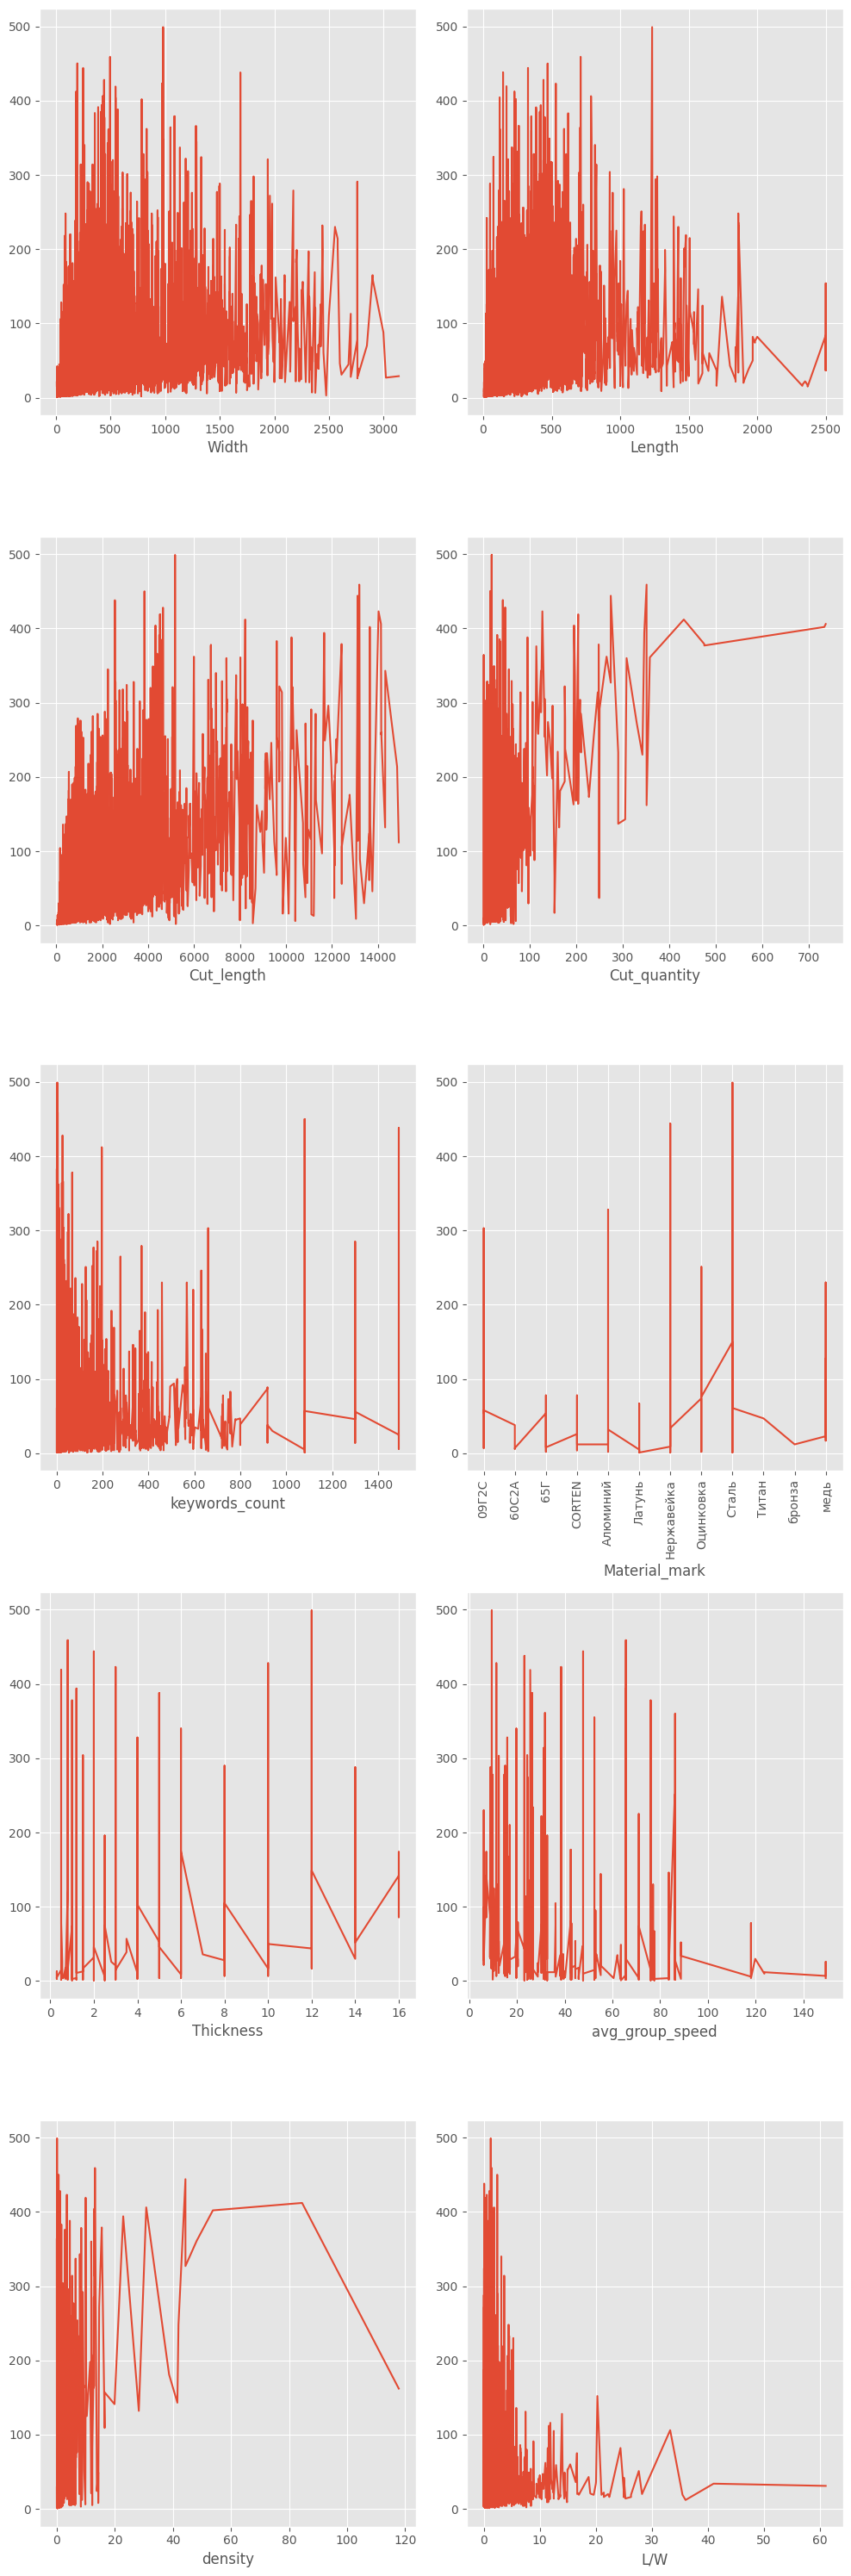

In [22]:
print_grafs(exp1, features, 2)

## Обучение моделей

Посмотрим на корреляционную матрицу, чтобы выбрать признаки для обучения

Сначала убираем нечисловые признаки

In [23]:
to_drop=['Part_name', 'Material', 'Operation', 'hash', 'keywords','Material_mark']
exp1.drop(to_drop, inplace=True, axis=1)

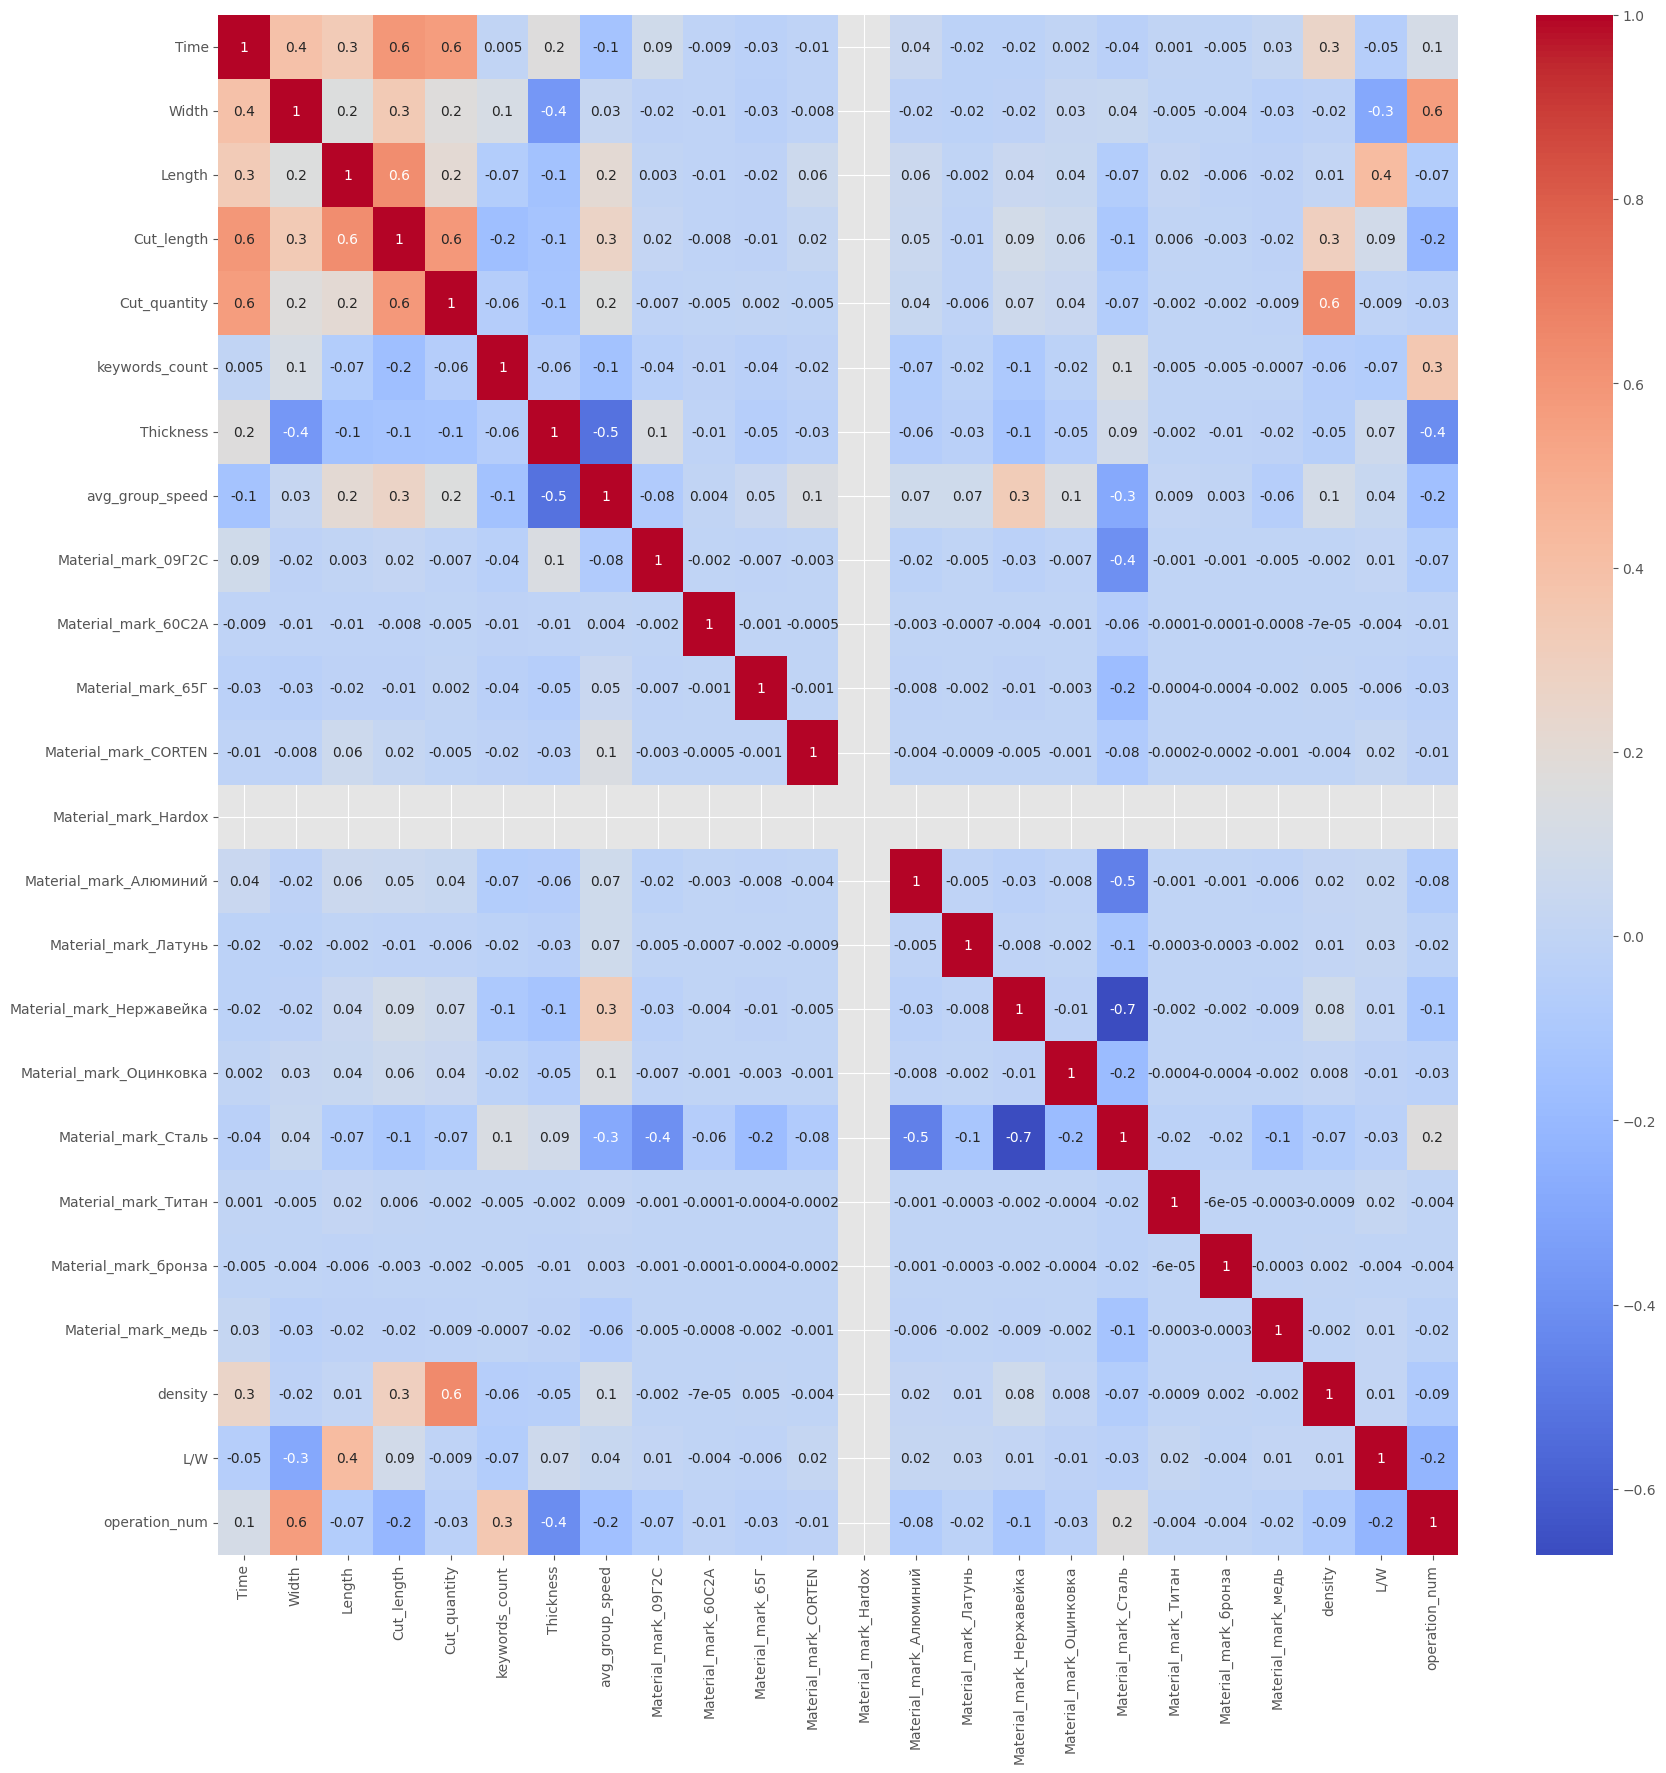

In [24]:
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(exp1.corr(), annot = True, ax=ax, fmt='.1g', cmap= 'coolwarm');

Для модели возьмем признаки, с корреляцией более 0.2

### Разделим на выборки

In [25]:
X = exp1.drop('Time', axis=1)
y = exp1['Time']

exp1_X_train, exp1_X_temp, exp1_y_train, exp1_y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42)

exp1_X_val, exp1_X_test, exp1_y_val, exp1_y_test = train_test_split(
    X, y, test_size=0.5, random_state=42)

Создадим датасет для сравнения, добавим baseline

### Baseline

Для baseline просто считаем по формуле

In [26]:
compare = exp1_X_test.copy()
compare['base_y_pred'] = compare['Cut_length'] / compare['avg_group_speed']
compare = compare.join(exp1_y_test)

Признаки и результаты будем упаковывать в датафрейм compare

In [27]:
compare[['base_y_pred', 'Time']].head(3)

,base_y_pred,Time
405302,68.148,70.000
250899,32.508,40.000
398875,21.668,19.000


На глаз, для первых 3 значений, предсказаниче получилось достаточно точным

Посчитаем метрики для baseline

In [28]:
actual_values = compare['Time']
predicted_values = compare['base_y_pred']

base_metrics=get_and_print_metrics(predicted_values, actual_values)

RMSE: 35.3924914358448
MAPE: 48.04%
SMAPE: 39.18%
R^2: 0.31
Процент значений с ошибкой не более 20%: 43.13%
WAPE: 41.87%


### Стандартная линейная регрессия

Обучаем линейную регрессию. Сначала стандартизируем данные

In [29]:
scaler = StandardScaler()
#scaler = QuantileTransformer(random_state=0)

exp1_X_train_scaled = pd.DataFrame(scaler.fit_transform(exp1_X_train),
                                   columns=exp1_X_train.columns, index=exp1_X_train.index)
exp1_X_val_scaled = pd.DataFrame(scaler.transform(exp1_X_val),
                                   columns=exp1_X_val.columns, index=exp1_X_val.index)

In [30]:
cols=['Cut_length', 'Material_mark_09Г2С', 'Material_mark_60С2А',
                 'Material_mark_65Г', 'Material_mark_CORTEN', 'Material_mark_Hardox',
                 'Material_mark_Алюминий', 'Material_mark_Латунь', 'Material_mark_Нержавейка',
                 'Material_mark_Оцинковка', 'Material_mark_Сталь', 'Material_mark_Титан',
                 'Material_mark_бронза', 'Cut_quantity', 'Thickness',
      'density', 'operation_num']
X = exp1_X_train[cols]
y = exp1_y_train

reg = LinearRegression()
reg.fit(X, y)
y_linear_exp1_predict = reg.predict(exp1_X_test[cols])
compare['y_linear_exp1_predict'] = y_linear_exp1_predict

In [31]:
linear_metrics = get_and_print_metrics(y_linear_exp1_predict, exp1_y_test)

RMSE: 24.6244781979202
MAPE: 68.21%
SMAPE: 51.05%
R^2: 0.67
Процент значений с ошибкой не более 20%: 31.81%
WAPE: 37.13%


## Сравнение baseline и regression

In [32]:
base_metrics['model_name'] = 'base'
linear_metrics['model_name'] = 'linear'

metrics_dicts = [
    base_metrics,
    linear_metrics,
]

# Создаем DataFrame из списка словарей
compare_metrics = pd.DataFrame(metrics_dicts)

# Переименуем столбец 'model_name' в индекс DataFrame
compare_metrics.set_index('model_name', inplace=True)

compare_metrics

,rmse,mape,smape,R^2,percentage_within_20,wape
model_name,,,,,,
base,35.392,0.480,39.181,0.310,43.131,41.873
linear,24.624,0.682,51.049,0.666,31.807,37.135


Видно, что rmse например, сильно лучше у регрессии, но зато процент(точнее 20) лучше у base. 

Нужно определится с метрикой, по которой будем выбирать модель.

Будем смотреть на wape, т.к нам важно не сильно ошибаться относительно каждой конкретной детали (с временем резки 1сек, 10сек, 100сек итд)





Для сравнения, посмотрим на графике, как распределены ошибки (в процентах)

In [33]:
def get_percent_error(pred, fact):
    error = abs(fact - pred)
    return error / fact * 100

In [34]:
compare['base_percent_error'] = compare.apply(lambda x: get_percent_error(x['base_y_pred'], x['Time']), axis=1)
compare['linear_percent_error'] = compare.apply(lambda x: get_percent_error(x['y_linear_exp1_predict'], x['Time']), axis=1)

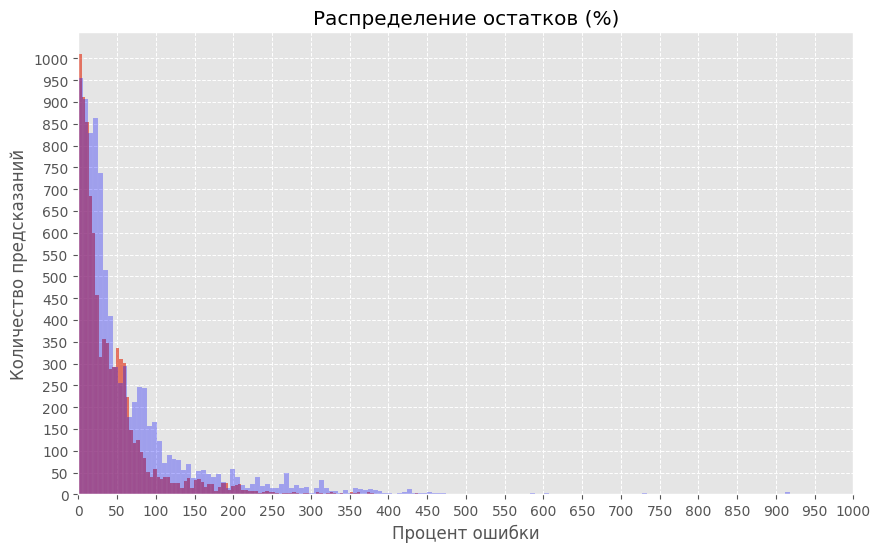

In [35]:
# Построение гистограммы с помощью Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(compare, x='base_percent_error')
sns.histplot(compare, x='linear_percent_error', color='blue', alpha=0.3)

# Ограничиваем значения по оси X до 1000
plt.xlim(0,1000)

# Задаем шаг для меток оси X (например, шаг 100)
step = 50
plt.xticks(np.arange(0, 1001, step))
plt.yticks(np.arange(0, 1001, step))

# Включаем сетку и задаем тот же шаг
plt.grid(True, axis='x', which='both', linestyle='--', linewidth=0.7)
plt.grid(True, axis='y', which='both', linestyle='--', linewidth=0.7)


# Добавим подписи и заголовок (если нужно)
plt.xlabel('Процент ошибки')
plt.ylabel('Количество предсказаний')
plt.title('Распределение остатков (%)')

plt.show()

Пока что нет, как минимум явного, преимущества перед базовой моделью. 

Регрессия дает больше предсказаний с ошибкой до 50%, но и больше с очень большой ошибкой (более 200%)

## Улучшение модели (регуляризация)

Попробуем добавить разные методы регуляризации

### lasso

In [36]:
search_lasso = GridSearchCV(estimator=Lasso(),
                           param_grid={'alpha': np.arange(0.01, 10, 0.05)})
search_lasso.fit(X,y)
best_lasso = search_lasso.best_estimator_
print("Best alpha:", best_lasso.alpha)

Best alpha: 0.01


In [37]:
lasso_reg = Lasso(alpha=best_lasso.alpha)
lasso_reg.fit(X, y)
y_lasso_exp1_predict = lasso_reg.predict(exp1_X_test[cols])
compare['y_lasso_exp1_predict'] = y_lasso_exp1_predict

In [38]:
lasso_metrics = get_and_print_metrics(y_lasso_exp1_predict, exp1_y_test)

RMSE: 24.629533842949336
MAPE: 67.73%
SMAPE: 50.69%
R^2: 0.67
Процент значений с ошибкой не более 20%: 31.98%
WAPE: 37.08%


### ridge

In [39]:
search_ridge = GridSearchCV(estimator=Ridge(),
                           param_grid={'alpha': np.arange(0.01, 10, 0.05)})
search_ridge.fit(X,y)
best_ridge = search_ridge.best_estimator_
print("Best alpha:", best_ridge.alpha)

Best alpha: 0.46


In [40]:
ridge_reg = Ridge(alpha=best_ridge.alpha)
ridge_reg.fit(X, y)
y_ridge_exp1_predict = ridge_reg.predict(exp1_X_test[cols])
compare['y_ridge_exp1_predict'] = y_ridge_exp1_predict

In [41]:
ridge_metrics = get_and_print_metrics(y_ridge_exp1_predict, exp1_y_test)

RMSE: 24.610268515514058
MAPE: 68.05%
SMAPE: 50.95%
R^2: 0.67
Процент значений с ошибкой не более 20%: 31.90%
WAPE: 37.09%


### ElasticNet

In [42]:
# Определение пространства поиска гиперпараметров
param_grid = {
    'alpha': np.logspace(-3, 3, 10),
    'l1_ratio': np.linspace(0.01, 1, 100)
}

# Инициализация RandomizedSearchCV
random_search_elnet = RandomizedSearchCV(
    estimator=ElasticNet(),
    param_distributions=param_grid,
    cv=5,  # Количество кросс-валидаций
    n_iter=50,  # Количество итераций для случайного подбора
    random_state=42,  # Для воспроизводимости результатов
)

# Подбор гиперпараметров
random_search_elnet.fit(X, y)

# Получение лучшей модели
best_random_elnet = random_search_elnet.best_params_

l1_ratio_best = best_random_elnet['l1_ratio']
alpha_best = best_random_elnet['alpha']

print(f"Best l1_ratio: {l1_ratio_best}")
print(f"Best alpha: {alpha_best}")

Best l1_ratio: 0.97
Best alpha: 0.001


In [43]:
elasticnet_reg = ElasticNet(alpha=0.001, l1_ratio=0.97)
elasticnet_reg.fit(X, y)
y_elasticnet_exp1_predict = elasticnet_reg.predict(exp1_X_test[cols])
compare['y_elasticnet_exp1_predict'] = y_elasticnet_exp1_predict

In [44]:
elasticnet_metrics = get_and_print_metrics(y_elasticnet_exp1_predict, exp1_y_test)

RMSE: 24.608966732446035
MAPE: 68.04%
SMAPE: 50.94%
R^2: 0.67
Процент значений с ошибкой не более 20%: 31.86%
WAPE: 37.09%


## Сравнение результатов

In [45]:
lasso_metrics['model_name'] = 'lasso'
elasticnet_metrics['model_name'] = 'elasticNet'
ridge_metrics['model_name'] = 'ridge'

In [46]:
metrics_dicts.extend(
    [lasso_metrics,
    elasticnet_metrics,
    ridge_metrics]
)

In [47]:
# Создаем DataFrame из списка словарей
compare_metrics = pd.DataFrame(metrics_dicts)

# Переименуем столбец 'model_name' в индекс DataFrame
compare_metrics.set_index('model_name', inplace=True)

compare_metrics

,rmse,mape,smape,R^2,percentage_within_20,wape
model_name,,,,,,
base,35.392,0.480,39.181,0.310,43.131,41.873
linear,24.624,0.682,51.049,0.666,31.807,37.135
lasso,24.630,0.677,50.689,0.666,31.976,37.079
elasticNet,24.609,0.680,50.942,0.666,31.863,37.088
ridge,24.610,0.680,50.950,0.666,31.897,37.091


Лучший wape - 37.079% у lasso, 

R^2 - у всех регрессий одинаковый,

Базовая модель дает 43.131% предсказаний, с ошибкой меньше 20%. Что лучше любой регрессии.

lasso - лучшая из регрессий, но не имеет явного преимущества перед baseline

Следующий шаг - попробовать полиномиальную регрессию

## Улучшение модели (полином)

Инициализирем полиномиальные признаки

In [48]:
poly_features = PolynomialFeatures(degree=2)

Трансформируем наши признаки в полином

In [49]:
X_poly = poly_features.fit_transform(pd.DataFrame(exp1_X_train[cols]))

Обучаем полиномиальную модель

In [50]:
reg_poly = LinearRegression()
reg_poly.fit(X_poly, exp1_y_train)
y_poly_predict = reg_poly.predict(poly_features.transform(exp1_X_test[cols]))

compare['y_poly_exp1_predict'] = y_poly_predict

y_poly_metrics = get_and_print_metrics(y_poly_predict, exp1_y_test)

RMSE: 17.66141560207329
MAPE: 25.75%
SMAPE: 21.61%
R^2: 0.83
Процент значений с ошибкой не более 20%: 65.23%
WAPE: 19.23%


In [51]:
new_row = pd.Series(y_poly_metrics.values(), 
                    index=['rmse', 'mape', 'smape', 'R^2', 'percentage_within_20', 'wape'])

# Добавляем новую строку в DataFrame
compare_metrics.loc['poly'] = new_row

In [52]:
compare_metrics 

,rmse,mape,smape,R^2,percentage_within_20,wape
model_name,,,,,,
base,35.392,0.480,39.181,0.310,43.131,41.873
linear,24.624,0.682,51.049,0.666,31.807,37.135
lasso,24.630,0.677,50.689,0.666,31.976,37.079
elasticNet,24.609,0.680,50.942,0.666,31.863,37.088
ridge,24.610,0.680,50.950,0.666,31.897,37.091
poly,17.661,0.258,21.615,0.828,65.227,19.229


# Визуализация результатов

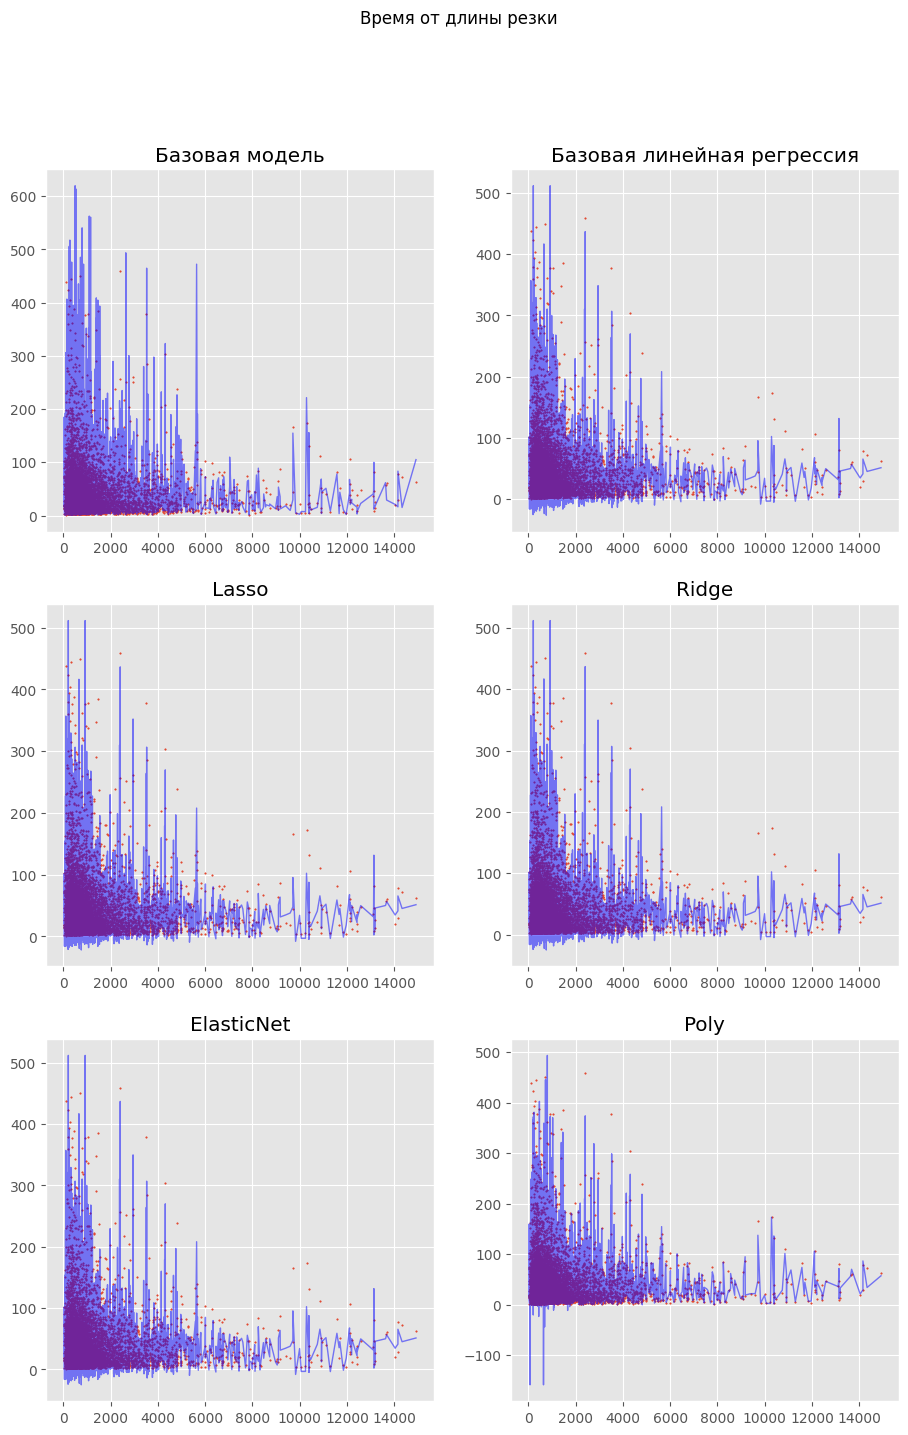

In [53]:
X = exp1_X_test['Cut_length'].sort_values()


fig, ax = plt.subplots(3, 2, figsize=(11,16))
fig.suptitle('Время от длины резки')


ax[0,0].scatter(X, exp1_y_test, s=1)
ax[0,1].scatter(X, exp1_y_test, s=1)
ax[1,0].scatter(X, exp1_y_test, s=1)
ax[1,1].scatter(X, exp1_y_test, s=1)
ax[2,0].scatter(X, exp1_y_test, s=1)
ax[2,1].scatter(X, exp1_y_test, s=1)


ax[0,0].set_title('Базовая модель')
ax[0,1].set_title('Базовая линейная регрессия')
ax[1,0].set_title('Lasso')
ax[1,1].set_title('Ridge')
ax[2,0].set_title('ElasticNet')
ax[2,1].set_title('Poly')


ax[0,0].plot(X, compare['base_y_pred'], lw=1, color = 'blue', alpha = 0.5)
ax[0,1].plot(X, compare['y_linear_exp1_predict'], lw=1, color = 'blue', alpha = 0.5)
ax[1,0].plot(X, compare['y_lasso_exp1_predict'], lw=1, color = 'blue', alpha = 0.5)
ax[1,1].plot(X, compare['y_ridge_exp1_predict'], lw=1, color = 'blue', alpha = 0.5)
ax[2,0].plot(X, compare['y_elasticnet_exp1_predict'], lw=1, color = 'blue', alpha = 0.5)
ax[2,1].plot(X, compare['y_poly_exp1_predict'], lw=1, color = 'blue', alpha = 0.5);

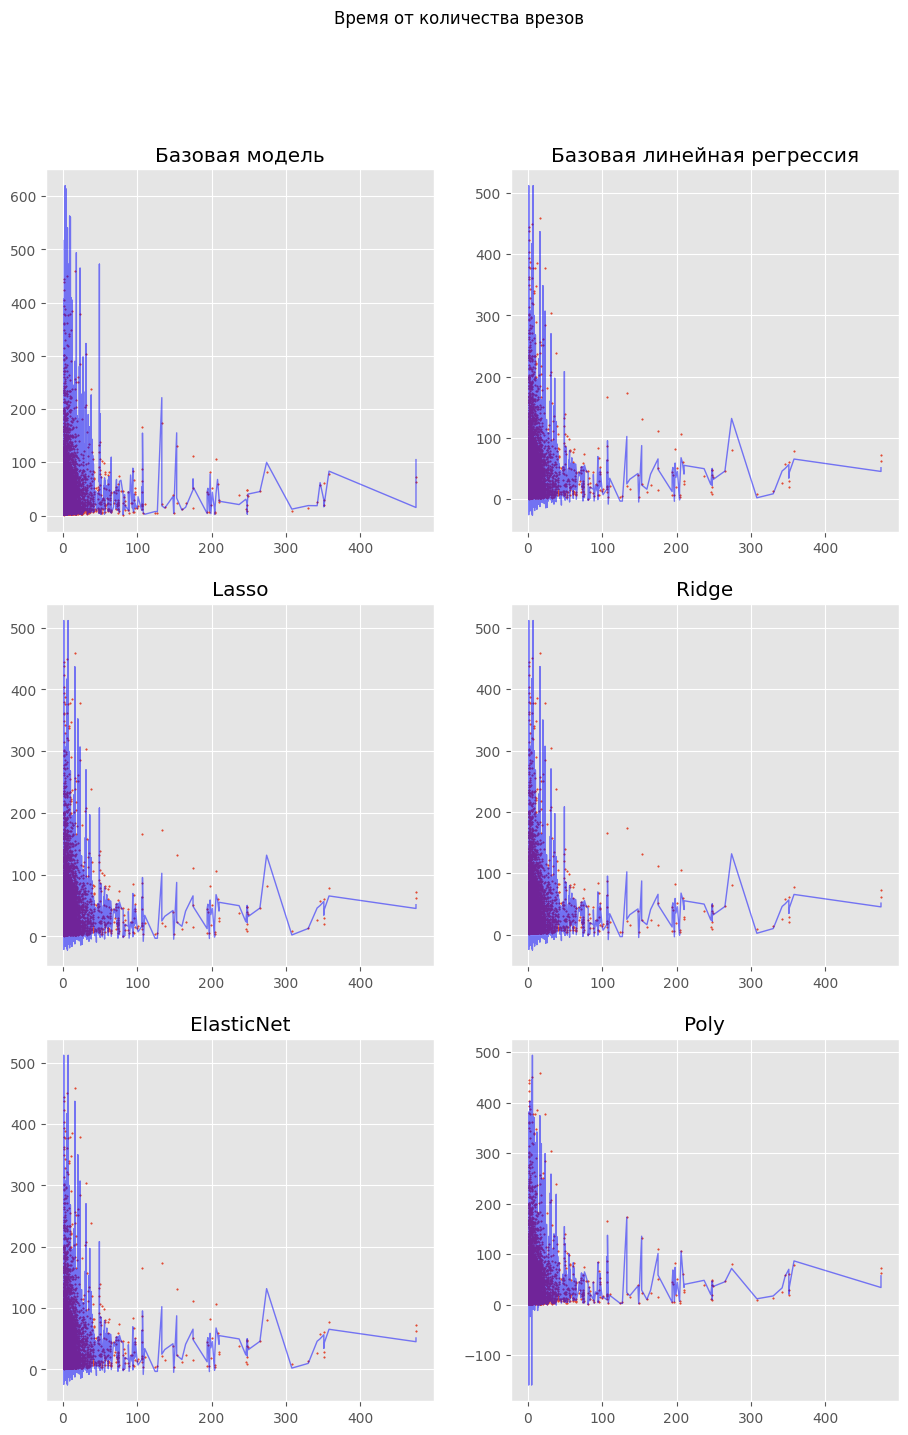

In [54]:
X = exp1_X_test['Cut_quantity'].sort_values()


fig, ax = plt.subplots(3, 2, figsize=(11,16))
fig.suptitle('Время от количества врезов')


ax[0,0].scatter(X, exp1_y_test, s=1)
ax[0,1].scatter(X, exp1_y_test, s=1)
ax[1,0].scatter(X, exp1_y_test, s=1)
ax[1,1].scatter(X, exp1_y_test, s=1)
ax[2,0].scatter(X, exp1_y_test, s=1)
ax[2,1].scatter(X, exp1_y_test, s=1)


ax[0,0].set_title('Базовая модель')
ax[0,1].set_title('Базовая линейная регрессия')
ax[1,0].set_title('Lasso')
ax[1,1].set_title('Ridge')
ax[2,0].set_title('ElasticNet')
ax[2,1].set_title('Poly')


ax[0,0].plot(X, compare['base_y_pred'], lw=1, color = 'blue', alpha = 0.5)
ax[0,1].plot(X, compare['y_linear_exp1_predict'], lw=1, color = 'blue', alpha = 0.5)
ax[1,0].plot(X, compare['y_lasso_exp1_predict'], lw=1, color = 'blue', alpha = 0.5)
ax[1,1].plot(X, compare['y_ridge_exp1_predict'], lw=1, color = 'blue', alpha = 0.5)
ax[2,0].plot(X, compare['y_elasticnet_exp1_predict'], lw=1, color = 'blue', alpha = 0.5)
ax[2,1].plot(X, compare['y_poly_exp1_predict'], lw=1, color = 'blue', alpha = 0.5);

ОТРИЦАТЕЛЬНЫЕ ПРЕДСКАЗАНИЯ - это чО такое то? ((((

In [55]:
compare[compare['y_poly_exp1_predict']<0]

,Width,Length,Cut_length,Cut_quantity,keywords_count,Thickness,avg_group_speed,Material_mark_09Г2С,Material_mark_60С2А,Material_mark_65Г,Material_mark_CORTEN,Material_mark_Hardox,Material_mark_Алюминий,Material_mark_Латунь,Material_mark_Нержавейка,Material_mark_Оцинковка,Material_mark_Сталь,Material_mark_Титан,Material_mark_бронза,Material_mark_медь,density,L/W,operation_num,base_y_pred,Time,y_linear_exp1_predict,base_percent_error,linear_percent_error,y_lasso_exp1_predict,y_ridge_exp1_predict,y_elasticnet_exp1_predict,y_poly_exp1_predict
121392,520.000,50.000,8728,351,8.000,1.200,65.548,0,0,0,0,0,0,0,0,0,1,0,0,0,117.828,0.096,1,133.154,162.000,153.776,17.806,5.076,154.489,153.719,153.748,-158.749
24178,32.000,8.000,79,1,10.000,1.000,86.245,0,0,0,0,0,0,0,1,0,0,0,0,0,0.309,0.250,1,0.916,3.000,-9.914,69.467,430.477,-9.580,-9.843,-9.835,-1.152
303797,10.000,10.000,31,1,54.000,2.000,47.721,0,0,0,0,0,0,0,1,0,0,0,0,0,0.310,1.000,1,0.650,1.000,-2.358,35.039,335.826,-2.036,-2.288,-2.280,-1.649
176035,20.000,20.000,63,1,134.000,2.000,23.124,0,0,0,0,0,0,0,0,0,1,0,0,0,0.158,1.000,1,2.724,2.000,-5.592,36.221,379.608,-5.468,-5.570,-5.567,-0.361
102603,33.000,33.000,129,4,1.000,1.500,83.605,0,0,0,0,0,1,0,0,0,0,0,0,0,0.474,1.000,1,1.543,4.000,15.213,61.426,280.314,15.642,15.295,15.320,-20.466
425726,36.000,36.000,164,2,399.000,1.500,71.039,0,0,0,0,0,0,0,0,1,0,0,0,0,0.253,1.000,1,2.309,4.000,-17.720,42.285,542.993,-13.633,-16.597,-16.566,-0.632
294251,60.000,10.000,138,1,1080.000,1.500,71.039,0,0,0,0,0,0,0,0,1,0,0,0,0,0.230,0.167,1,1.943,2.000,-18.850,2.870,1042.507,-14.762,-17.728,-17.696,-1.474
23902,16.000,16.000,61,1,134.000,2.000,23.124,0,0,0,0,0,0,0,0,0,1,0,0,0,0.238,1.000,1,2.638,2.000,-5.789,31.896,389.464,-5.665,-5.767,-5.764,-0.122
146945,37.000,24.000,119,1,1080.000,1.000,76.034,0,0,0,0,0,0,0,0,0,1,0,0,0,0.134,0.649,1,1.565,2.000,-12.971,21.746,748.533,-12.835,-12.948,-12.944,-0.205
146953,25.000,50.000,141,1,1080.000,1.000,76.034,0,0,0,0,0,0,0,0,0,1,0,0,0,0.113,2.000,1,1.854,2.000,-12.563,7.278,728.128,-12.428,-12.540,-12.536,-0.028


# Итог

С линейной регрессией не получилось добиться значительного улучшения относительно базовой модели.

Незначительно улучшение дает lasso регуляризация. 

Для улучшение модели можно попробовать изменить предобработку данных

Следующий шаг - использование mlflow для автоматизации процесса (отдельный блокнот)